In [152]:
#%%
import math
import numpy as np
import inspect
import importlib

import scipy.interpolate

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.offline import plot
pio.renderers.default = "svg"

import sys
import os
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
#sys.path.append(os.path.dirname(parent_directory))
#sys.path.append(os.path.dirname(os.path.dirname(parent_directory)))

from IoT_node_models.Energy_model                        import *
from IoT_node_models.Energy_model.Wireless_communication import *
from IoT_node_models.Hardware_Modules                    import *
from IoT_node_models.Impact_model                        import *
import LoRaNode_analysis as nd

path_to_save_svg = "Saved_Data"



Importing Impact models
Importing Impact models


In [138]:
dictColor = {"DeepBlue"     :"#095256",
             "LightBlue"    :"#01a7c2",
             "UnitedBlue"   :"#6290c8",
             "CerulBlue"    :"#6096ba",
             "Green"        :"#44af69",
             "LightRed"     :"#f8333c",
             "DeepRed"      :"#a22c29",
             "Orange"       :"#fcab10",
             "Sandy"        :"#fc9e4F",
             "Olivine"      :"#9ab87a",
             "CarolinaBlue" :"#009DDC"}
listColor = list(dictColor.values())

In [139]:
RX_module_3V3 = Node_module(name="LoRa radio",
                            v=3.3,
                            i_sleep=6e-3)
RX_state_TX_3V3 = Module_state("TX",i = 52,duration = None)
RX_state_RX_3V3 = Module_state("RX",i = 22,duration = None)
RX_module_3V3.add_state(RX_state_TX_3V3)
RX_module_3V3.add_state(RX_state_RX_3V3)



WuRX_module_3V3 = Node_module(name="WuLoRa radio",
                            v=3.3,
                            i_sleep=100e-3)
WuRX_state_TX_3V3 = Module_state("TX",i = 52,duration = None)
WuRX_state_RX_3V3 = Module_state("RX",i = 22,duration = None)
WuRX_module_3V3.add_state(WuRX_state_TX_3V3)
WuRX_module_3V3.add_state(WuRX_state_RX_3V3)


DCWuRX_module_3V3 = Node_module(name="Duty-cycled Wu",
                            v=3.3,
                            i_sleep=6e-3)
DCWuRX_state_TX_3V3 = Module_state("TX",i = 52,duration = None)
DCWuRX_state_RX_3V3 = Module_state("RX",i = 22,duration = None)
DCWuRX_state_Wu_3V3 = Module_state("Wu",i = 2,duration = None)
DCWuRX_module_3V3.add_state(DCWuRX_state_TX_3V3)
DCWuRX_module_3V3.add_state(DCWuRX_state_RX_3V3)
DCWuRX_module_3V3.add_state(DCWuRX_state_Wu_3V3)


MCU_module_3V3 = Node_module(name="Apollo3",
                            v      =3.3,
                            i_sleep=0)
MCU_state_active_3V3  = Module_state("Active",i = 0,duration = None)
MCU_module_3V3.add_state(MCU_state_active_3V3)

In [140]:
task_wu_3V3 =  Node_task(  name = "Duty-cycled Wu", 
                        node_modules= [MCU_module_3V3,WuRX_module_3V3], 
                        #moduleUsed = [  apollo_module_3V3,
                        #                radio_module_3V3], 
                        subtasks   = [   Node_subtask(name='Proc',module=MCU_module_3V3,
                                        moduleState = MCU_state_active_3V3, stateDuration=0),
                                         Node_subtask(name='RX'  ,module=DCWuRX_module_3V3 ,
                                        moduleState = DCWuRX_state_Wu_3V3     , stateDuration=10e-3)], 
                        taskDuration = 100e-3, 
                         )

In [141]:
node_LDO = LDO(name = "Node LDO", v_out = 3.3, i_q = 0, v_in = 3.3, module_list = [MCU_module_3V3,RX_module_3V3])
node_Batt= Battery(name = "Node Batt.", v = 3.3, capacity_mAh = 1800, i = 0, selfdischarge_p_year = 0)

node_lora = LoRa_Node(name= "IoT Node", module_list= [MCU_module_3V3,RX_module_3V3], PMU_composition =[node_LDO], Battery = node_Batt, MCU_module   = MCU_module_3V3, radio_module = RX_module_3V3)

node = LoRa_Node_profile("Node_profile", node_lora, MCU_active_state = MCU_state_active_3V3,
                radio_state_TX=RX_state_TX_3V3, radio_state_RX= RX_state_RX_3V3, Ptx = 2)
#########################################################################################################################""
Wunode_LDO = LDO(name = "Node LDO", v_out = 3.3, i_q = 0, v_in = 3.3, module_list = [MCU_module_3V3,WuRX_module_3V3])
Wunode_Batt= Battery(name = "Node Batt.", v = 3.3, capacity_mAh = 1800, i = 0, selfdischarge_p_year = 0)

Wunode_lora = LoRa_Node(name= "IoT Node", module_list= [MCU_module_3V3,WuRX_module_3V3], PMU_composition =[Wunode_LDO], Battery = Wunode_Batt, MCU_module   = MCU_module_3V3, radio_module = WuRX_module_3V3)

Wunode = LoRa_Node_profile("Node_profile", Wunode_lora, MCU_active_state = MCU_state_active_3V3,
                radio_state_TX=WuRX_state_TX_3V3, radio_state_RX= WuRX_state_RX_3V3, Ptx = 2)
#########################################################################################################################""
DCWunode_LDO = LDO(name = "Node LDO", v_out = 3.3, i_q = 0, v_in = 3.3, module_list = [MCU_module_3V3,DCWuRX_module_3V3])
DCWunode_Batt= Battery(name = "Node Batt.", v = 3.3, capacity_mAh = 1800, i = 0, selfdischarge_p_year = 0)

DCWunode_lora = LoRa_Node(name= "IoT Node", module_list= [MCU_module_3V3,DCWuRX_module_3V3], PMU_composition =[DCWunode_LDO], Battery = Wunode_Batt, MCU_module   = MCU_module_3V3, radio_module = DCWuRX_module_3V3)

DCWunode = LoRa_Node_profile("Node_profile", DCWunode_lora, MCU_active_state = MCU_state_active_3V3,
                radio_state_TX=DCWuRX_state_TX_3V3, radio_state_RX= DCWuRX_state_RX_3V3, Ptx = 2)                   
    

node.set_radio_parameters(SF=7 ,Coding=1,Header=True,DE = None,BW = 125e3, Payload = 50) 
node.change_task_rate(node.task_rx,0)#24*60*(60/6))
node.change_task_rate(node.task_tx,0)

Wunode.set_radio_parameters(SF=7 ,Coding=1,Header=True,DE = None,BW = 125e3, Payload = 50) 
Wunode.change_task_rate(Wunode.task_rx,0)#24*60*(60/6))
Wunode.change_task_rate(Wunode.task_tx,0)

DCWunode.set_radio_parameters(SF=7 ,Coding=1,Header=True,DE = None,BW = 125e3, Payload = 50) 
DCWunode.change_task_rate(DCWunode.task_rx,0)#24*60*(60/6))
DCWunode.change_task_rate(DCWunode.task_tx,0)
DCWunode.add_task(task_wu_3V3,0)

In [142]:
figsize = (6,5)

In [143]:
def compute_PreambleSampling(Node,TX_rate,PreambleTime,SF,BW,Payload,capacity_mAh,CAD_duration,verbose=False):
    Node.set_radio_parameters(SF=SF,BW = BW,Payload=Payload)
    preamble_time = preamble_ToA(SF=SF,B = BW)
    Node.change_TX_duration(Node.radio_subtask_Tx.stateDuration - preamble_time + PreambleTime)
    Node.change_RX_duration(CAD_duration)
    Node.change_MCU_RX_duration(0)
    Node.change_task_rate(Node.task_tx,TX_rate)
    Node.change_task_rate(Node.task_rx,(24*60*60)/PreambleTime)
    Node.get_Node().get_Battery().set_capacity_mAh( capacity_mAh )
    Node.compute()
    if verbose:
        print(Node.lifetime)
        print(Node.average_power)
    return [Node.average_power, Node.lifetime]

def compute_WuPreambleSampling(Node,TX_rate,PreambleTime,SF,BW,Payload,capacity_mAh,Task_Wu):
    Node.set_radio_parameters(SF=SF,BW = BW,Payload=Payload)
    preamble_time = preamble_ToA(SF=SF,B = BW)
    Node.change_TX_duration(Node.radio_subtask_Tx.stateDuration - preamble_time + PreambleTime)
    Node.change_RX_duration(250e-3)
    Node.change_MCU_RX_duration(0)
    Node.change_task_rate(Node.task_tx,TX_rate)
    Node.change_task_rate(Node.task_rx,TX_rate)
    Node.change_task_rate(Task_Wu,(24*60*60)/PreambleTime)
    Node.get_Node().get_Battery().set_capacity_mAh( capacity_mAh )
    Node.compute()
    return [Node.average_power, Node.lifetime]


def compute_Wu(Node,TX_rate,SF,BW,Payload,capacity_mAh):
    Node.set_radio_parameters(SF=SF,BW = BW,Payload=Payload)
    Node.change_RX_duration(250e-3)
    Node.change_MCU_RX_duration(0)
    Node.change_task_rate(Node.task_tx,TX_rate)
    Node.change_task_rate(Node.task_rx,TX_rate)
    Node.get_Node().get_Battery().set_capacity_mAh( capacity_mAh )
    Node.compute()
    return [Node.average_power, Node.lifetime]

In [144]:
compute_PreambleSampling(node,TX_rate=24,PreambleTime=0.5,SF=7,BW=125e3,Payload=30,capacity_mAh=2500,CAD_duration=10e-3,verbose=False)

[1.498065275344, 0.6286647433981457]

In [145]:
def sweep_PreambleTime(node,TX_rate,PreambleTime,SF,BW,Payload,capacity_mAh,CAD_duration):
    results = np.zeros((len(TX_rate),len(PreambleTime),2))
    for i, tx_rate in enumerate(TX_rate):
        for j, preambTime in enumerate(PreambleTime):
            results[i,j,:] = compute_PreambleSampling(node,TX_rate=tx_rate,PreambleTime=preambTime,SF=SF,BW=BW,Payload=Payload,
                                                    capacity_mAh=capacity_mAh,CAD_duration=CAD_duration,verbose=False)
    return results   

def sweep_WuPreambleTime(node,TX_rate,PreambleTime,SF,BW,Payload,capacity_mAh,Task_Wu):
    results = np.zeros((len(TX_rate),len(PreambleTime),2))
    for i, tx_rate in enumerate(TX_rate):
        for j, preambTime in enumerate(PreambleTime):
            results[i,j,:] = compute_WuPreambleSampling(node,TX_rate=tx_rate,PreambleTime=preambTime,SF=SF,BW=BW,Payload=Payload,
                                                    capacity_mAh=capacity_mAh,Task_Wu=Task_Wu)
    return results 

def sweep_WuTX_rate(node,TX_rate,SF,BW,Payload,capacity_mAh):
    results = np.zeros((len(TX_rate),2))
    for i, tx_rate in enumerate(TX_rate):
        results[i,:] = compute_Wu(node,TX_rate=tx_rate,SF=SF,BW=BW,Payload=Payload,
                                                capacity_mAh=capacity_mAh)
    return results 

In [146]:
PreambleTime = np.linspace(0.2,16,20)
TX_rate      = np.array([1,4,12,48,24*6])
CAD_dur   = 10e-3
CAD_durWu = 10e-3
SF      = 7
BW      = 500e3
Payload = 30
capac   = 2500
res     = sweep_PreambleTime  (    node,TX_rate=TX_rate,PreambleTime=PreambleTime,SF=SF,BW=BW,Payload=Payload,capacity_mAh=capac,CAD_duration=CAD_dur)
resDCWu = sweep_WuPreambleTime(DCWunode,TX_rate=TX_rate,PreambleTime=PreambleTime,SF=SF,BW=BW,Payload=Payload,capacity_mAh=capac,Task_Wu=task_wu_3V3)
resWu   = sweep_WuTX_rate     (  Wunode,TX_rate=TX_rate,                          SF=SF,BW=BW,Payload=Payload,capacity_mAh=capac)
print(resWu)

[[0.33024476 2.8517661 ]
 [0.33097906 2.84543932]
 [0.33293717 2.82870436]
 [0.34174868 2.7557702 ]
 [0.36524603 2.57848337]]


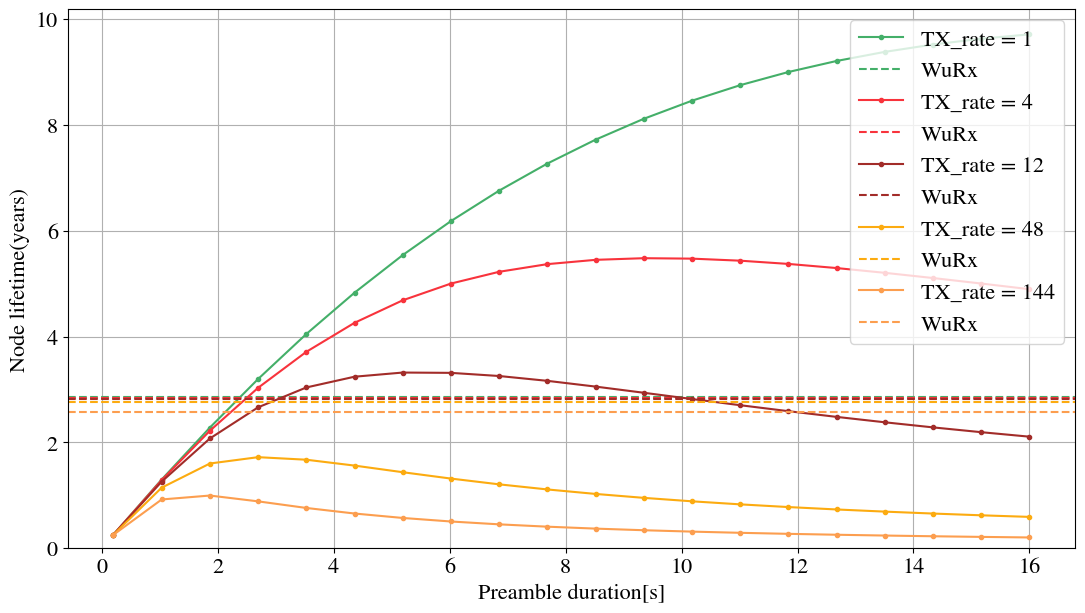

In [150]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(13,7))

lines   = ["-","--","-.",":","-","--","-.",":"]
markers = [".","v","*","1","+","x"]
colorOffset = 4
markersize = 8
f=0
for t,txr in enumerate(TX_rate):
    ax.plot(PreambleTime, res    [t,:,1] , marker=".", color = listColor[(t+colorOffset)]  , label= ("TX_rate = "+str(txr)) )
    #ax.plot(PreambleTime, resDCWu[t,:,1] , marker="*", color = listColor[(t+colorOffset)]  , label= ("TX_rate = "+str(txr)) )
    ax.axhline(y=resWu[t,1], xmin=0,xmax=PreambleTime[-1], linestyle = lines[1], color = listColor[(t+colorOffset)] , label=("WuRx")) 

ax.set_xlabel("Preamble duration[s]")
ax.set_ylabel("Node lifetime(years)")
ax.set_ylim([0,None])
ax.grid()
ax.legend( loc="upper right")
#ax.set_title("DER vs SNR of CSS @FAR : "+str(fa_rate[0])+" FA/h")
plt.show()

16.0
0.09696622248622222


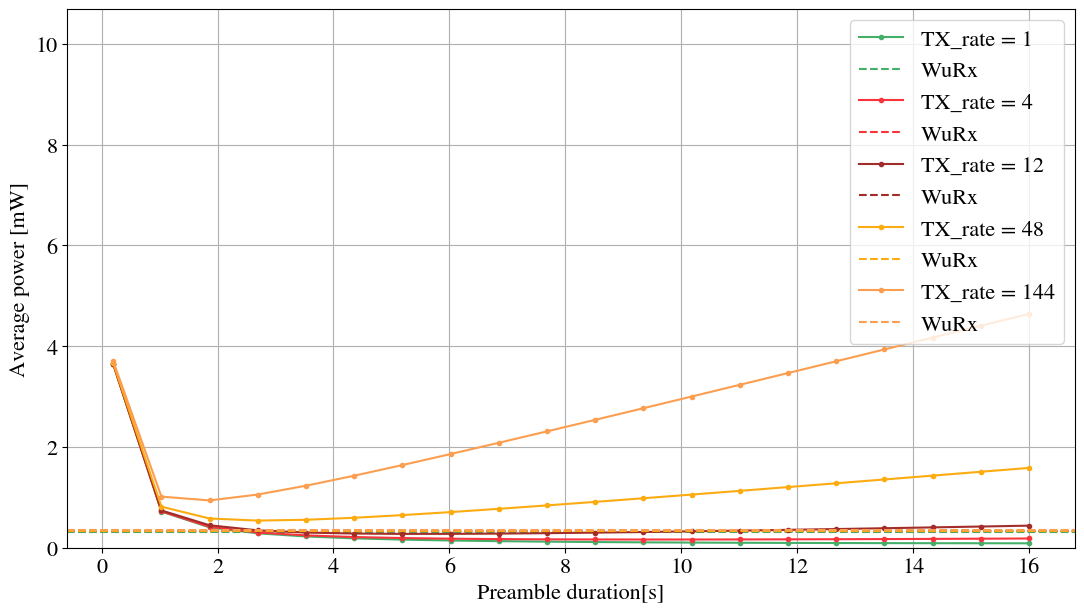

In [149]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(13,7))

lines   = ["-","--","-.",":","-","--","-.",":"]
markers = [".","v","*","1","+","x"]
colorOffset = 4
markersize = 8
f=0
for t,txr in enumerate(TX_rate):
    ax.plot(PreambleTime,     res[t,:,0] , marker=".", color = listColor[(t+colorOffset)]  , label= ("TX_rate = "+str(txr)) ) 
    #ax.plot(PreambleTime, resDCWu[t,:,0] , marker="*", color = listColor[(t+colorOffset)]  , label= ("TX_rate = "+str(txr)) )
    ax.axhline(y=resWu[t,0], xmin=0,xmax=PreambleTime[-1], linestyle = lines[1], color = listColor[(t+colorOffset)] , label=("WuRx")) 

print(PreambleTime[np.argmin(res[:,:,0])])
print(np.min(res[:,:,0]))
ax.set_xlabel("Preamble duration[s]")
ax.set_ylabel("Average power [mW]")
ax.set_ylim([0,np.max(res)*1.1])
ax.grid()
ax.legend( loc="upper right")
#ax.set_title("DER vs SNR of CSS @FAR : "+str(fa_rate[0])+" FA/h")
plt.show()

-------------------------------------------------
            Tasks summary                        
-------------------------------------------------
Task name            : Sleep          TX             RX             Duty-cycled Wu 
Times/day    [1/d]   : 1              144            144            5400.0         
Tot. durat.  [s]     : 83474.6619     2349.3381      36.0000        540.0000       
Tot. en./d   [mJ]    : 1652.7983      395734.1554    2613.6000      27.4428        
Node en./d   [mJ]    : 400027.9965     
Average pow. [mW]    : 4.6300          
-------------------------------------------------
-----------------------------------------------------------------
                        Module summary                           
-----------------------------------------------------------------
Module       State        Active [s]   Energy [mJ]  Av. Cur.[uA]  
Apollo3                   43.2000      0.0000       0.0000        
     -       Sleep        86356.8000   0.0000       

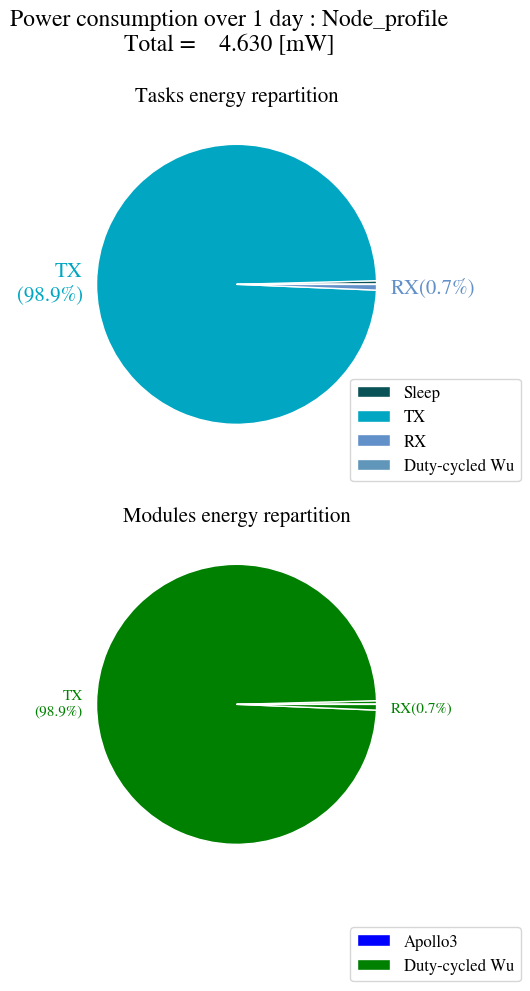

In [135]:
DCWunode.print_Tasks()
DCWunode.print_Modules()
DCWunode.plot_Power()

-------------------------------------------------
            Tasks summary                        
-------------------------------------------------
Task name            : Sleep          TX             RX             
Times/day    [1/d]   : 1              48             48             
Tot. durat.  [s]     : 86372.7368     15.2632        12.0000        
Tot. en./d   [mJ]    : 28503.0031     152.8826       871.2000       
Node en./d   [mJ]    : 29527.0857      
Average pow. [mW]    : 0.3417          
-------------------------------------------------
-----------------------------------------------------------------
                        Module summary                           
-----------------------------------------------------------------
Module       State        Active [s]   Energy [mJ]  Av. Cur.[uA]  
Apollo3                   14.4000      0.0000       0.0000        
     -       Sleep        86385.6000   0.0000       
     -       Active       14.4000      0.0000       
WuLoRa

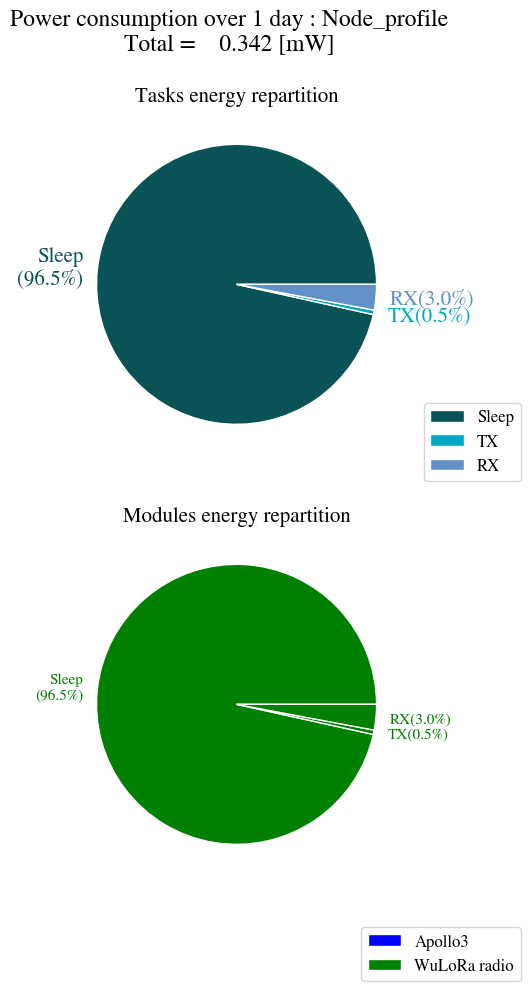

In [97]:
Wunode.print_Tasks()
Wunode.print_Modules()
Wunode.plot_Power()

-------------------------------------------------
            Tasks summary                        
-------------------------------------------------
Task name            : Sleep          TX             RX             
Times/day    [1/d]   : 1              48             5400.0         
Tot. durat.  [s]     : 85562.8873     783.1127       54.0000        
Tot. en./d   [mJ]    : 1694.1452      131911.3851    3920.4000      
Node en./d   [mJ]    : 137525.9303     
Average pow. [mW]    : 1.5917          
-------------------------------------------------
-----------------------------------------------------------------
                        Module summary                           
-----------------------------------------------------------------
Module       State        Active [s]   Energy [mJ]  Av. Cur.[uA]  
Apollo3                   14.4000      0.0000       0.0000        
     -       Sleep        86385.6000   0.0000       
     -       Active       14.4000      0.0000       
LoRa r

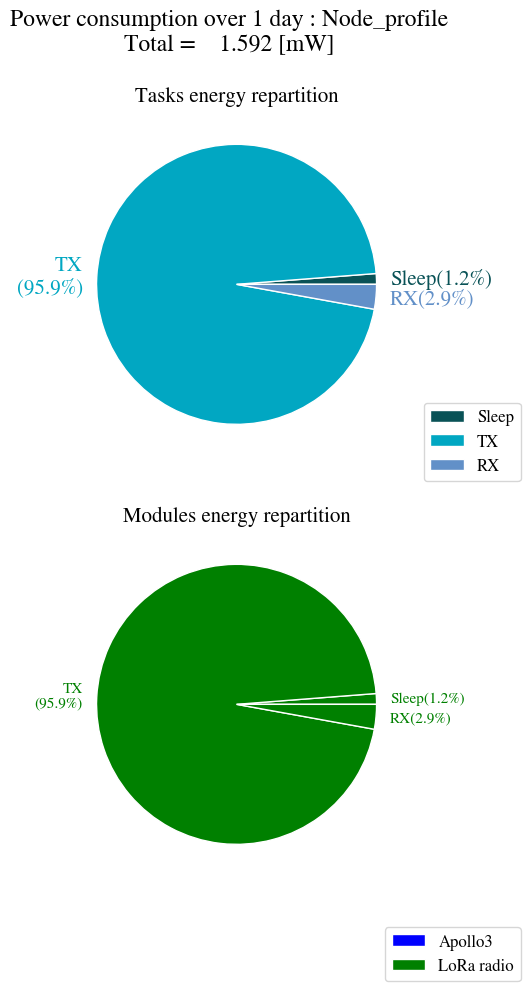

In [98]:
node.print_Tasks()
node.print_Modules()
node.plot_Power()

In [153]:
show = 0

AA_series = 3
AA_footprint = 0.165
AA_cost      = 0.25 
Batt_footprint = AA_series*AA_footprint
Batt_cost      = AA_series*AA_cost

placementNnodes   = 100
decomNnodes       = 100
replacementNnodes = 10

transport_f =   transport_footprint(km_one_way = 10, 
                                    type ="Unit", 
                                    weight_g = 500,  
                                    footprint_p_tkm = 0.545,
                                    unit_factor = 1,
                                    footprint_p_km = 0.350)

node_footprint = Node_BoM(  casing            =[0.709,    0.3932, 1.3259], #709
                            connectivtiy      =[0.517,    0.2262, 0.5817],
                            eol               =[0.0812,   0.0388, 0.1201],
                            memory            =[0,        0,      0     ],
                            others            =[0.0938,   0.0546, 0.1394],
                            pcb               =[1.17,     0.9403, 1.5696], #1.17
                            power_supply      =[0.132,    0.0446, 0.1751],
                            processing        =[0.366,    0.3665, 0.4537],
                            sensing           =[0.0539,   0.0539, 0.5561],
                            ui                =[0.0306,   0.0017, 0.1155],
                            transport         =[transport_f*show,transport_f*show,transport_f*show],
                            battery           =[Batt_footprint  ,Batt_footprint,Batt_footprint],
                            placement         =[transport_f,transport_f,transport_f],
                            replacement       =[transport_f,transport_f,transport_f],
                            decom             =[transport_f,transport_f,transport_f], 
                            placementNnodes   = placementNnodes,
                            decomNnodes       = decomNnodes,
                            replacementNnodes = replacementNnodes)
    

3.6485000000000003


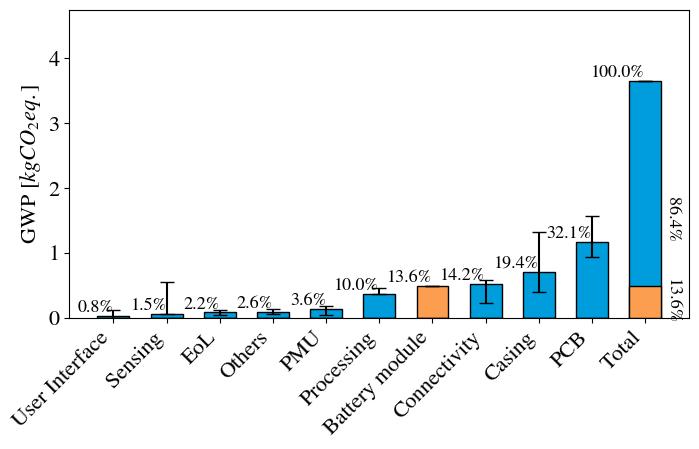

In [154]:
node_footprint.plot_footprint(filename = os.path.join(path_to_save_svg , "Node_Footprint_breakdown") ,figsize =(8,4),separatePlot=False)

In [163]:
[res1,res2,lifetime,residue] =deployment_battery_replacement(
                                    Replacement_type = "Complete",
                                    Footprint=node_footprint,
                                    Node=node,
                                    Nyears= 20)
print([res1,res2,lifetime,residue])

[21.514950000000013, 21.392620035949616, 0.5916692425874783, 1.5917353043386666]


In [185]:
def set_PreambleSampling(Node,TX_rate,PreambleTime,SF,BW,Payload,capacity_mAh,CAD_duration):
    Node.set_radio_parameters(SF=SF,BW = BW,Payload=Payload)
    preamble_time = preamble_ToA(SF=SF,B = BW)
    Node.change_TX_duration(Node.radio_subtask_Tx.stateDuration - preamble_time + PreambleTime)
    Node.change_RX_duration(CAD_duration)
    Node.change_MCU_RX_duration(0)
    Node.change_task_rate(Node.task_tx,TX_rate)
    Node.change_task_rate(Node.task_rx,(24*60*60)/PreambleTime)
    Node.get_Node().get_Battery().set_capacity_mAh( capacity_mAh )

def compute_ImpactsPreamSamp(Node,Footprint,TX_rate,PreambleTime,SF,BW,Payload,capacity_mAh,CAD_duration,Nyears = 20,Replacement_type = "Complete"):
    set_PreambleSampling(Node=Node,TX_rate=TX_rate,PreambleTime=PreambleTime,SF=SF,BW=BW,
                            Payload=Payload,capacity_mAh=capacity_mAh,CAD_duration=CAD_duration)
    [res1,res2,lifetime,residue] =deployment_battery_replacement(
                                    Replacement_type = Replacement_type,
                                    Footprint=Footprint,
                                    Node=Node,
                                    Nyears= Nyears)
    return [res2,lifetime]
    

In [161]:
compute_ImpactsPreamSamp(node,node_footprint,48,16,7,BW,Payload,capac,CAD_dur)

[21.514950000000013,
 21.392620035949616,
 0.5916692425874783,
 1.5917353043386666]

In [169]:
def impact_sweep_PreambleTime(node,Footprint,TX_rate,PreambleTime,SF,BW,Payload,capacity_mAh,CAD_duration,Nyears = 20,Replacement_type = "Complete"):
    results = np.zeros((len(TX_rate),len(PreambleTime),2))
    for i, tx_rate in enumerate(TX_rate):
        for j, preambTime in enumerate(PreambleTime):
            results[i,j,:] = compute_ImpactsPreamSamp(node,Footprint,TX_rate=tx_rate,PreambleTime=preambTime,SF=SF,BW=BW,Payload=Payload,
                                                    capacity_mAh=capacity_mAh,CAD_duration=CAD_duration,Nyears=Nyears,Replacement_type=Replacement_type)
    return results

In [190]:
PreambleTime = np.linspace(0.1,16,60)
TX_rate      = np.array([3,12,48,48*4])
CAD_dur   = 10e-3
CAD_durWu = 10e-3
SF      = 7
BW      = 500e3
Payload = 30
capac   = 2500

node_LDO.i_q = 1e-3
node_Batt.set_selfdischarge_p_year(5)
res_impact= impact_sweep_PreambleTime(  node, node_footprint,
                                        TX_rate=TX_rate,PreambleTime=PreambleTime,
                                        SF=SF,BW=BW,Payload=Payload,capacity_mAh=capac,CAD_duration=CAD_dur)


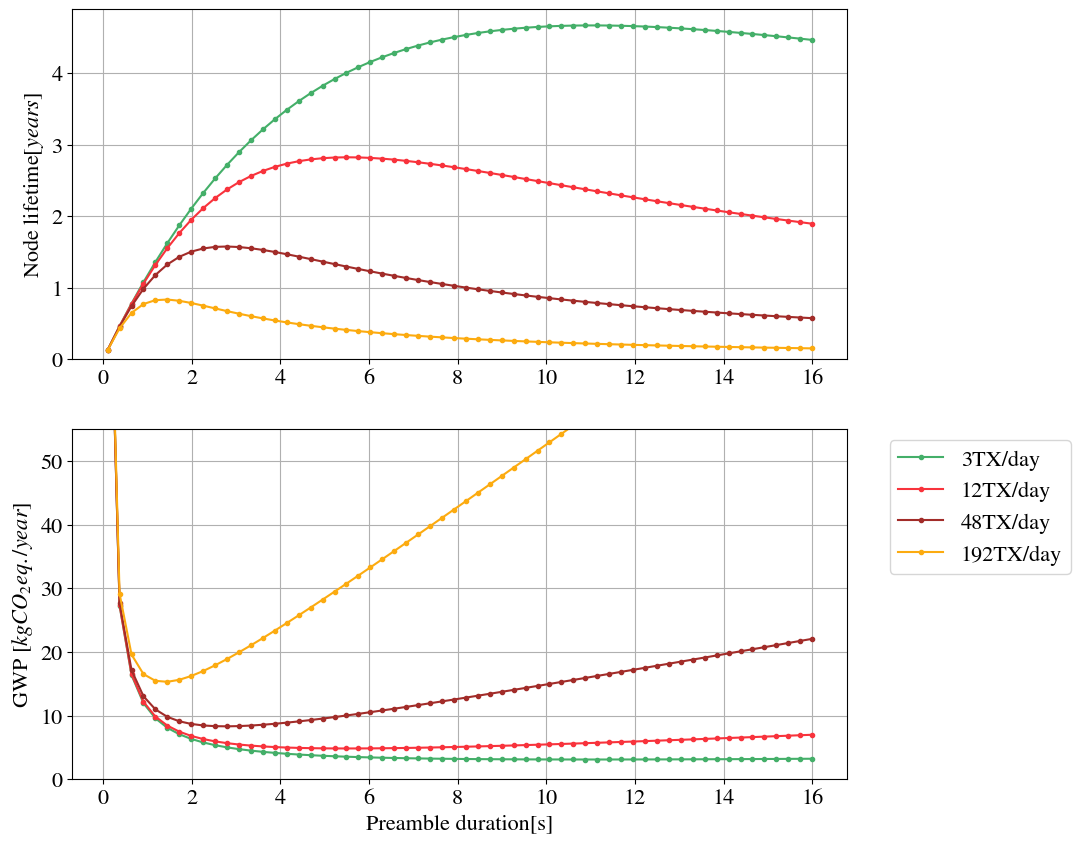

In [198]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2,1,figsize=(10,10))

lines   = ["-","--","-.",":","-","--","-.",":"]
markers = [".","v","*","1","+","x"]
colorOffset = 4
markersize = 8
f=0
for t,txr in enumerate(TX_rate):
    ax[0].plot(PreambleTime, res_impact[t,:,1] , marker=".", color = listColor[(t+colorOffset)]  , label= (str(txr)+"TX/day") )

for t,txr in enumerate(TX_rate):
    ax[1].plot(PreambleTime, res_impact[t,:,0] , marker=".", color = listColor[(t+colorOffset)]  , label= (str(txr)+"TX/day") )



ax[1].set_xlabel("Preamble duration[s]")
ax[1].set_ylabel("GWP [$kgCO_2eq./year$]")
ax[1].set_ylim([0,55])
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.04,1), loc="upper left")

#ax[0].set_xlabel("Preamble duration[s]")
ax[0].set_ylabel("Node lifetime[$years$]")
ax[0].set_ylim([0,None])
ax[0].grid()

#ax.set_title("DER vs SNR of CSS @FAR : "+str(fa_rate[0])+" FA/h")
plt.show()